# District Heating Plant Dispatch Optimization

This tutorial will guide you through the optimization of a district heating plant's dispatch using Python and PuLP. Ensure you have the required data files: `heat_demand.csv`, `electric_demand.csv`, `S2_el_prices_SE42023.csv`, `eon_elprice.csv`, and `SAFT_steam.csv`.

## Step 1: Import Libraries

In [2]:
# Import required libraries
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import pulp as pl
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Instruction: Ensure you have all the required libraries installed. 
# If not, install them using pip commands like `pip install pulp pandas matplotlib numpy`.


## Step 2: Reading Input Data

In [3]:
# Function to read input data
def read_input_data():
    heat_demand = pd.read_csv('heat_demand.csv', index_col=False)
    el_demand = pd.read_csv('electricity_demand.csv', index_col=False)
    el_prices = pd.read_csv('el_prices_SE42023.csv', index_col=False)
    eon_elprice = pd.read_csv('elprice.csv', index_col=False)
    MAN_steam = pd.read_csv('steam.csv', index_col=False)
    return heat_demand, el_demand, el_prices, eon_elprice, MAN_steam

# Read the data
heat_demand, el_demand, el_prices, eon_elprice, MAN_steam = read_input_data()

# Instruction: Ensure the CSV files are in the same directory as your notebook or provide the correct path.


FileNotFoundError: [Errno 2] No such file or directory: 'electric_demand.csv'

## Step 3: Define Capacities and Storage Parameters

In [3]:
# Capacities and storage parameters
resources_heat = {
    'CHP_heat': {'min': 6, 'max': 29.5, 'efficiency': 1, 'cost': 196.3, 'CO2': 11},
    'WC1_boiler': {'min': 1.5, 'max': 9, 'efficiency': 0.85, 'cost': 195.4, 'CO2': 11},
}

resources_el = {'CHP_el': {'min': 0.8, 'max': 3.9, 'efficiency': 0.95, 'cost': 248.5}}
steam_chp_cost = 196.3
steam_VV_cost = 195.3
HP = {'min': 5, 'max': 20, 'COP': 3.5}

interval = 8760
results = pd.DataFrame(index=heat_demand.index)
end_state = 0

### Step 3.3 Interval

In [4]:
interval = 8760
results = pd.DataFrame(index=heat_demand.index)
end_state = 0

## Step 4: Initialize the Optimization Problem and Define Decision Variables

In [5]:
for i in range(len(heat_demand) // interval):
    start_idx = i * interval
    end_idx = (i + 1) * interval

    prob = LpProblem("District Heating Plant Dispatch Optimization", LpMinimize)
    Storage_state = 0

    variables = LpVariable.dicts("Fuel", ((r, t) for r in resources_heat for t in range(start_idx, end_idx)), lowBound=0, cat='Continuous')
    b_heat = LpVariable.dicts("b_heat", ((r, t) for r in resources_heat for t in heat_demand.index), cat="Integer")
    b_HP = LpVariable.dicts("b_HP", [t for t in range(start_idx, end_idx)], cat="Integer")
    HP_heat = LpVariable.dicts("HP", [t for t in range(start_idx, end_idx)], lowBound=0, cat='Continuous')
    steam_chp = LpVariable.dicts("steam_chp", [t for t in range(start_idx, end_idx)], lowBound=0, upBound=3.7, cat='Continuous')
    steam_VV = LpVariable.dicts("steam_VV", [t for t in range(start_idx, end_idx)], lowBound=0, upBound=4.8, cat='Continuous')
    chp_load = LpVariable.dict("CHP Load", [t for t in range(start_idx, end_idx)], lowBound=0, cat='Continuous')
    buy_el = LpVariable.dict("Buy Electricity", [t for t in range(start_idx, end_idx)], lowBound=0, cat='Continuous')
    b_el = LpVariable.dict("b_el", [t for t in range(start_idx, end_idx)], cat="Integer")

## Step 4: Define the Objective Function

In [6]:
for i in range(len(heat_demand) // interval):
    start_idx = i * interval
    end_idx = (i + 1) * interval

    prob += lpSum([variables[(r, t)] * resources_heat[r]['cost'] for r in resources_heat for t in range(start_idx, end_idx)]) \
        + lpSum([HP_heat[t] * (1 / HP['COP']) * float(el_prices.loc[t].to_numpy()) for t in range(start_idx, end_idx)]) \
        + lpSum([steam_VV[t] * steam_VV_cost for t in range(start_idx, end_idx)]) \
        + lpSum([steam_chp[t] * steam_chp_cost for t in range(start_idx, end_idx)]) \
        - (lpSum([el_demand.loc[t] * eon_elprice.loc[t] for t in range(start_idx, end_idx)]) \
        + lpSum([(chp_load[t] - el_demand.loc[t]) * float(el_prices.loc[t].to_numpy()) for t in range(start_idx, end_idx)]) \
        - lpSum(chp_load[t] * resources_el['CHP_el']['cost'] for t in range(start_idx, end_idx)) \
        - lpSum(buy_el[t] * float(el_prices.loc[t].to_numpy()) for t in range(start_idx, end_idx)))

## Step 5: Add Constraints

In [7]:
for i in range(len(heat_demand) // interval):
    start_idx = i * interval
    end_idx = (i + 1) * interval
    for t in range(start_idx, end_idx):

        
        # Electricity
        
        prob += chp_load[t] + buy_el[t] >= el_demand.loc[t] #electricity production + bought has to meet eon's demand
        prob += chp_load[t] <= lpSum(resources_el['CHP_el']['max'] * b_el[t]) #maximum CHP turbine load 
        prob += chp_load[t] >= lpSum(resources_el['CHP_el']['min']*b_el[t]) # minimum CHP turbine load
        
       
        prob += buy_el[t] >= 0 #electricity bought must be grater than 0 (also specified in the lower boundary of the variable but this caused some trouble)
        prob += b_el[t] >=0 # Binary variables can only take the values of 0 or 1. These variable could also be defined as Binary in the variable definition part, but they didn't work correctly
        prob += b_el[t] <=1# Binary variables can only take the values of 0 or 1. 
        prob += chp_load[t] <= 0.25*(variables[('CHP_heat', t)]) #Alpha value of the CHP system
        

        #Maintenance stops as per 2022 data
              
        if t in range(3862, 5837):
            
            prob += b_heat[('CHP_heat', t)]==0
            prob += variables[('CHP_heat', t)]==0
            prob += steam_chp[t]==0
        
        
        if t in range(3862, 5981): #Turbine takes a little longer than the CHP boiler to re-start
            prob += chp_load[t]==0
        
        
        if t in range(2989, 3855) or t in range(5893, 7633):
            prob += b_heat[('WC1_boiler', t)]==0 #WC1 Boiler stops in May-June
            prob += steam_VV[t]==0

        # Total heat production
        
        heat_production = lpSum([variables[(r, t)]  for r in resources_heat]) + HP_heat[t]
        
       # Total heat production must equal the demand + the heat stored
       
        prob += heat_production == heat_demand.loc[t]
       
       # Total steam production must equal the demand 
    
        prob+= steam_chp[t] + steam_VV[t] >= MAN_steam.loc[t]
       
        
        # Binary variable for the boilers
        
        for r in resources_heat:
            
            prob += b_heat[(r, t)] >=0
            prob += b_heat[(r, t)] <=1
        
        # Minimum and maximum capacity constraints
        
        prob += b_HP[t] >=0
        prob += b_HP[t] <=1
        prob += HP_heat[t] <= HP['max']*b_HP[t]
        prob += HP_heat[t] >= HP['min']*b_HP[t]
        prob += variables[('CHP_heat', t)]+steam_chp[t] <=resources_heat['CHP_heat']['max']*b_heat[('CHP_heat', t)]
        prob += variables[('CHP_heat', t)]+steam_chp[t] >=resources_heat['CHP_heat']['min']*b_heat[('CHP_heat', t)]
        prob += variables[('WC1_boiler', t)]+steam_VV[t] <=resources_heat['WC1_boiler']['max']*b_heat[('WC1_boiler', t)]
        prob += variables[('WC1_boiler', t)]+steam_VV[t] >=resources_heat['WC1_boiler']['min']*b_heat[('WC1_boiler', t)]

## Step 6: Solve the Optimization Problem

In [8]:
for i in range(len(heat_demand) // interval):
    
    # start and end indices for the r interval
    
    start_idx = i * interval
    end_idx = (i + 1) * interval
    
    prob.solve(GUROBI_CMD(msg=True))

    # Define decision variables
    chp_heat = {}
    Steam_chp = {}
    WC1 = {}
    Steam_VV = {}
    bio_oil_1 = {}
    bio_oil_2 = {}
    wood_pellets_1 = {}
    wood_pellets_2 = {}
    bio_oil_3 = {}  
    HP_h = {}
    Buy_el={}
    Chp_load={}



    # Populate the results DataFrame with the optimal values of the decision variables

    for p in range(start_idx, end_idx):
        
        chp_heat[p] = variables[('CHP_heat', p)]
        Steam_chp[p] = steam_chp[p]
        WC1[p] = variables[('WC1_boiler', p)]
        Steam_VV[p] = steam_VV[p]      
        HP_h[p] = HP_heat[p]
        Buy_el[p] = buy_el[p]
        Chp_load[p] = chp_load[p]

    for q in range(start_idx, end_idx):
        
        
        results.loc[q, 'KVV_total'] = chp_heat[q].varValue + Steam_chp[q].varValue
        results.loc[q, 'VV_total'] = WC1[q].varValue + Steam_VV[q].varValue     
        results.loc[q, 'HP_heat'] = HP_h[q].varValue
        results.loc[q, 'CHP_heat'] = chp_heat[q].varValue
        results.loc[q, 'WC1_boiler'] = WC1[q].varValue
        results.loc[q, 'buy_el'] = Buy_el[q].varValue
        results.loc[q, 'chp_el'] = Chp_load[q].varValue
        results.loc[q, 'CHP_steam'] = Steam_chp[q].varValue
        results.loc[q, 'WC1_steam'] = Steam_VV[q].varValue


results.to_excel("results_General.xlsx", index=False)



## Step 7: Visualize Results

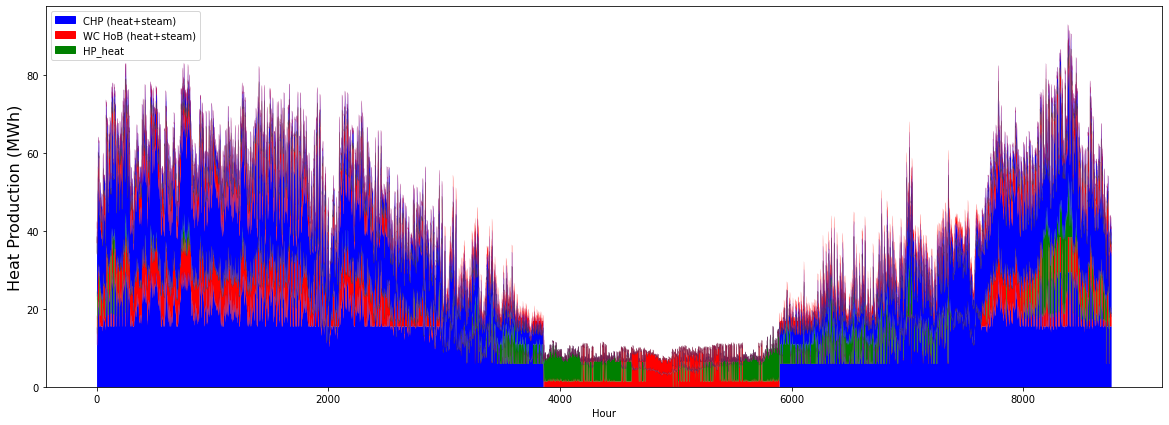

In [11]:
colors = {'CHP (heat+steam)': 'blue', 
          'WC HoB (heat+steam)': 'red', 
          'HP_heat': 'green'}

ax = results.iloc[:, :8].plot.area(stacked=True, figsize=(20,7), color=colors.values(), linewidth=0.05)


# Axis labels and title
ax.set_xlabel('Hour')
ax.set_ylabel('Heat Production (MWh)', fontsize=16)
#ax.set_title('Heat Production by technology', fontsize=16)

#ax.set_xlim([4080, 4104])

# legend
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in colors]
labels = colors.keys()
ax.legend(handles, labels)


# Plot
plt.show()